## Introduction
This is a project using the https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data data and training a simple MultiLayer Perceptron to predict future energy loads

## Load

Load model hyperparameters from JSON file

In [1]:
# Load configuration from a JSON file
import json
with open("config1.json", "r") as f:
    config = json.load(f)

# Access parameters like:
num_samples = config["data_params"]["num_samples"]
max_int = config["data_params"]["max_int"]

#input_dim = config["model_params"]["input_dim"]
hidden_dim = config["model_params"]["hidden_dim"]
output_dim = config["model_params"]["output_dim"]

learning_rate = config["training_params"]["learning_rate"]
batch_size = config["training_params"]["batch_size"]
window_length = config["training_params"]["window_length"]
num_epochs = config["training_params"]["num_epochs"]

print("Loaded configuration:")
print(config)

Loaded configuration:
{'data_params': {'num_samples': 1000, 'max_int': 128}, 'model_params': {'model': 'MLP', 'input_dim': 24, 'hidden_dim': 512, 'output_dim': 1}, 'training_params': {'learning_rate': 0.001, 'batch_size': 128, 'window_length': 24, 'num_epochs': 100, 'optimizer': 'Adam'}, 'log_params': {'experiment_name': 'experiment_001', 'notes': 'Baseline experiment with MLP'}}


## Data
Import libraries

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


Connect to dataset via Kaggle API

In [3]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

print("Path to dataset files:", path)

/Users/paolo/Desktop/Projects/Solo/energy-load-MLP/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/paolo/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3


Check datasets


In [4]:
print(os.listdir(path))

['est_hourly.paruqet', 'PJMW_hourly.csv', 'pjm_hourly_est.csv', 'PJM_Load_hourly.csv', 'DAYTON_hourly.csv', 'NI_hourly.csv', 'PJME_hourly.csv', 'FE_hourly.csv', 'DOM_hourly.csv', 'EKPC_hourly.csv', 'DEOK_hourly.csv', 'DUQ_hourly.csv', 'AEP_hourly.csv', 'COMED_hourly.csv']


(FROM KAGGLE, adapted) functions for plotting data

This function selects one of the column (e.g. load values in MW) and plots its value distribution

In [5]:
# Distribution graphs (histogram/bar graph) of column data
def plotDistribution(df, plotCol, nBins, title=None, xlabel=None, ylabel="counts"):
    # plotCol is 1-based index, convert to 0-based
    col_idx = plotCol - 1
    columnNames = list(df)
    # Check if col_idx is within the valid range
    if col_idx < 0 or col_idx >= len(columnNames):
        raise IndexError(f"plotCol {plotCol} is out of range")
    # Get the specific column data
    columnDf = df.iloc[:, col_idx]
    # Set up the plot
    plt.figure(figsize=(6, 8), dpi=80, facecolor='w', edgecolor='k')
    # Determine if the column is categorical or numerical
    if not np.issubdtype(columnDf.dtype, np.number):
        columnDf.value_counts().plot.bar()
    else:
        columnDf.hist(bins=nBins)
    # Labeling the plot
    plt.xlabel(xlabel if xlabel is not None else columnNames[col_idx])
    plt.ylabel(ylabel)
    plt.title(title if title is not None else f'{columnNames[col_idx]} (column {plotCol})')
    plt.xticks(rotation=90)
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()

### File 1: AEP_hourly.csv

Select number of rows to plot

In [6]:
nRowsRead = None # specify 'None' if want to read whole file
# AEP_hourly.csv has 121273 rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv(os.path.join(path, "AEP_hourly.csv"), delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'AEP_hourly.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 121273 rows and 2 columns


Let's take a quick look at what the data looks like:

In [7]:
df1.head(5)

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


Distribution graphs (histogram/bar graph) of sampled column:

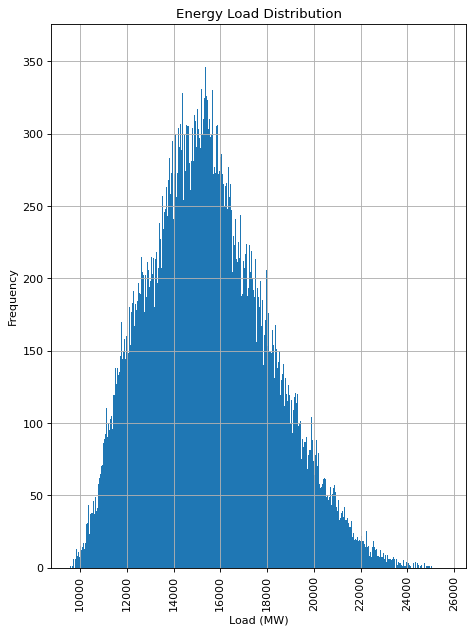

In [8]:
plotDistribution(
    df1, 2, 1000,
    title="Energy Load Distribution",
    xlabel="Load (MW)",
    ylabel="Frequency"
)

### File 2: COMED_hourly.csv

In [12]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# COMED_hourly.csv has 66497 rows in reality, but we are only loading/previewing the first 1000 rows
df2 = pd.read_csv(os.path.join(path,'COMED_hourly.csv'), delimiter=',', nrows = nRowsRead)
df2.dataframeName = 'COMED_hourly.csv'
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 2 columns


Let's take a quick look at what the data looks like:

In [13]:
df2.head(5)

,Datetime,COMED_MW
0,2011-12-31 01:00:00,9970.0
1,2011-12-31 02:00:00,9428.0
2,2011-12-31 03:00:00,9059.0
3,2011-12-31 04:00:00,8817.0
4,2011-12-31 05:00:00,8743.0


Distribution graphs (histogram/bar graph) of sampled columns:

In [14]:
plotPerColumnDistribution(df2, 10, 5)

<Figure size 2400x512 with 0 Axes>

### File 3: DAYTON_hourly.csv

In [15]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# DAYTON_hourly.csv has 121275 rows in reality, but we are only loading/previewing the first 1000 rows
df3 = pd.read_csv(os.path.join(path,'DAYTON_hourly.csv'), delimiter=',', nrows = nRowsRead)
df3.dataframeName = 'DAYTON_hourly.csv'
nRow, nCol = df3.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 2 columns


Let's take a quick look at what the data looks like:

In [16]:
df3.head(5)

,Datetime,DAYTON_MW
0,2004-12-31 01:00:00,1596.0
1,2004-12-31 02:00:00,1517.0
2,2004-12-31 03:00:00,1486.0
3,2004-12-31 04:00:00,1469.0
4,2004-12-31 05:00:00,1472.0


Distribution graphs (histogram/bar graph) of sampled columns:

In [17]:
plotPerColumnDistribution(df3, 10, 5)

<Figure size 2400x512 with 0 Axes>

## Model
In this section we define the MLP which we will train on the data

### Imports

Begin by importing the necessary libraries

In [6]:
# Let us start by importing the necessary libraries
import torch  # Main framework for defining and training the transformer
import torch.nn as nn  # Neural network module
import torch.optim as optim  # Optimization functions
import itertools  # (Optional) For generating structured datasets
import math  # For mathematical operations

import time # For timing the training process

import json # For saving and loading the model

from torch.nn.utils.rnn import pad_sequence # For padding sequences to the same length

### Model

Define a simple Multilayer Perceptron

In [7]:
# Also define a simple MLP model for comparison
class MLP(nn.Module):
    def __init__(self, input_dim=window_length, hidden_dim=128, output_dim=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)  # No activation on output (for regression)
        return x

# define model
#model = ModuloTransformer(num_primes=len(primes), d_model=256, num_heads=4, num_layers=2, hidden_dim=256)
model = MLP(input_dim=window_length, hidden_dim=hidden_dim, output_dim=output_dim)

## Training

### Data setup

Import libraries to package data into batches and in the appropriate format to feed into the training

In [8]:
from torch.utils.data import TensorDataset, DataLoader  # To handle training data efficiently

Load dataset AEP_hourly.csv containing the American Electric Power hourly energy consumption

Note: we use this dataset as example, but the process can be repeated with the other sets

In [9]:
# Load AEP data
# Import csv as pandas DataFrame
df = pd.read_csv(f"{path}/AEP_hourly.csv")
# convert "Datetime" strings to datetime type
df["Datetime"] = pd.to_datetime(df["Datetime"])
# NOTE data is not ordered properly, see eg
# print((df["Datetime"][20:24+1]))
# hence order
df = df.sort_values("Datetime")

# take all MW energy load entries as a numpy array of float32
# NB float32 works better with PyTorch
series = df["AEP_MW"].values.astype(np.float32)

# Sliding window
# create input vectors X containing L consecutive values for the energy loads
# create target values y containing the next value after each input vector
L = window_length  # window length; change as desired
X = np.array([series[i:i+L] for i in range(len(series) - L)], dtype=np.float32)
y = np.array([series[i+L] for i in range(len(series) - L)], dtype=np.float32)
# convert y to (num_samples, 1) shape ie into a 2D array, needed to agree with MLP shape
y = y.reshape(-1, 1)

# check
print(X.shape, y.shape)

(121249, 24) (121249, 1)


Split data into:

(1) training set, used to train the model

(2) validation set, used during the training to test the model (e.g. to avoid overfitting)

(3) testing set, used to test the model after the training

Then package into the appropriate PyTorch formats

In [10]:
# X: (n, L), y: (n, 1)
n = len(X)
# define (integer) boundaries for train/val/test splits
train_end = int(n * 0.7)
val_end = int(n * 0.85)

# implement splits
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

# normalise data (z-score normalisation)
# NB standardize using train stats only
mean = X_train.mean(axis=0, keepdims=True)
std = X_train.std(axis=0, keepdims=True) + 1e-8
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

# Torch datasets/loaders
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

Display the first batch of data as a check

In [11]:
# Check one batch of data
for batch in train_loader:
    inputs, targets = batch  # Unpack batch
    print(f"Batch Inputs (time series): {inputs.shape}")  # Should be (batch_size, window_length)
    print(f"Batch Inputs (time series): {inputs}")
    print(f"Batch Targets (next step): {targets.shape}")  # Should be (batch_size,1)
    print(f"Batch Targets (next step): {targets}")
    break  # Only print the first batch

Batch Inputs (time series): torch.Size([128, 24])
Batch Inputs (time series): tensor([[ 0.4007,  0.2990,  0.1361,  ...,  0.3037,  0.3845,  0.2867],
        [ 0.1621,  0.4224,  0.3537,  ..., -0.9796, -0.8500, -0.4737],
        [-0.9395, -1.0396, -0.9507,  ..., -0.8493, -0.9536, -1.0972],
        ...,
        [-0.1879, -0.5084, -0.7509,  ...,  0.4485,  0.1800, -0.2856],
        [ 1.5561,  1.8847,  2.0974,  ..., -0.7794, -0.2588,  0.1303],
        [-0.2069,  0.1500,  0.4162,  ..., -0.2794, -0.2324, -0.1238]])
Batch Targets (next step): torch.Size([128, 1])
Batch Targets (next step): tensor([[16110.],
        [16182.],
        [12644.],
        [23426.],
        [15708.],
        [20359.],
        [16361.],
        [20801.],
        [16874.],
        [14485.],
        [13143.],
        [19589.],
        [17793.],
        [14522.],
        [15856.],
        [11320.],
        [17890.],
        [19420.],
        [11171.],
        [16718.],
        [18531.],
        [17019.],
        [19412.],

### Training loop

Define the training loop and train the model.

Note:

(1) we use Mean Squared Loss as a loss function, since the output is a float representing the energy power in MW

(2) we leave the option to turn on a scheduler to update the learining rate during training

(3) we keep track of both training and validation loss, e.g. to make sure the model is training but not overfitting

In [12]:
# Now we define the training loop
# We define the loss function (Mean Squared Error) and the optimizer (Adam)
# Then we iterate over the data in batches, perform forward pass, compute loss, backpropagate and update weights

# Define Mean Squared Error loss (for regression)
#loss_fn = nn.MSELoss()
# Define Cross Entropy loss (for classification)
loss_fn = nn.MSELoss()

# Define Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)  # Reduce LR by gamma after step_size epochs
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)  # Cosine annealing scheduler, gradually reduces learning rate, specify eta_min=X for minimum LR value (default 0)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)  # Reduce LR on plateau, reduce LR by factor of 0.5 if validation loss does not improve for 10 epochs

# Check output for a single training step
#optimizer.zero_grad()  # Reset gradients
#test_outputs = model(test_inputs)  # Forward pass (predict N)
#test_loss = loss_fn(test_outputs, test_targets)  # Compute loss
#test_loss.backward()  # Backpropagation
#optimizer.step()  # Update weights
#print("Model Output After One Training Step:")
#print(model(test_inputs))


start_time = time.time()  # Track how long training takes

# Training loop
for epoch in range(num_epochs):
    train_loss = 0.0  # Track total loss for the epoch
    model.train()  # Set model to training mode

    for inputs, targets in train_loader:  # Iterate over batches
        optimizer.zero_grad()  # Reset gradients
        outputs = model(inputs)  # Forward pass (predict N)
        loss = loss_fn(outputs, targets)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        train_loss += loss.item()  # Keep track of loss

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs} | train {train_loss:.4f} | val {val_loss:.4f}")

    # Step the scheduler every epoch
    #scheduler.step()
    # Use for the ReduceLROnPlateau scheduler
    #scheduler.step(total_loss)

print(f"Training completed in {time.time() - start_time:.2f} seconds")  # Print total time

Epoch 1/100 | train 67859747.0075 | val 10579786.7032
Epoch 2/100 | train 2882355.4729 | val 337572.9402
Epoch 3/100 | train 226316.8645 | val 142360.4173
Epoch 4/100 | train 132316.3191 | val 94995.9657
Epoch 5/100 | train 94505.5671 | val 70959.0202
Epoch 6/100 | train 74670.8230 | val 54534.1648
Epoch 7/100 | train 64722.7336 | val 48113.2614
Epoch 8/100 | train 60028.2724 | val 47414.6304
Epoch 9/100 | train 57793.1256 | val 53154.8832
Epoch 10/100 | train 56295.2997 | val 47766.2634
Epoch 11/100 | train 56013.7025 | val 44344.4758
Epoch 12/100 | train 55298.4734 | val 46224.6003
Epoch 13/100 | train 54561.4276 | val 69002.8967
Epoch 14/100 | train 55116.1175 | val 44379.1321
Epoch 15/100 | train 54295.0166 | val 41716.6603
Epoch 16/100 | train 53930.0591 | val 47145.4674
Epoch 17/100 | train 53824.5643 | val 46056.1636
Epoch 18/100 | train 53415.2024 | val 48961.8391
Epoch 19/100 | train 53065.7844 | val 40930.8296
Epoch 20/100 | train 52698.1573 | val 41454.8349
Epoch 21/100 | tr

## Testing

We can now test the trained model

We begin by computing mean squared error (MSE), root mean squared error (RMSE) and mean absolute error (MAE) with respect to the testing set

In [13]:
# Testing
model.eval()
test_loss = 0.0
preds = []
targets_all = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        test_loss += loss.item()

        preds.append(outputs.cpu())
        targets_all.append(targets.cpu())

test_loss /= len(test_loader)

preds = torch.cat(preds).numpy()
targets_all = torch.cat(targets_all).numpy()

# Metrics
mse = ((preds - targets_all) ** 2).mean()
rmse = np.sqrt(mse)
mae = np.abs(preds - targets_all).mean()

print(f"Test MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

Test MSE: 29234.6641 | RMSE: 170.9815 | MAE: 127.4107


Then we compare MSE/RMSE/MAE against a simple baseline, obtained by using the MW value for the last hour (in each sequence in X_test) as prediction for the next hour. If the model has trained well we expect it to give better results than this baseline

In [14]:
# De-normalize last input value to MW
last_norm = X_test[:, -1]  # z-score-normalized last value
last_raw = last_norm * std[0, -1] + mean[0, -1] # de-normalize

baseline_pred = last_raw
baseline_true = y_test.squeeze()

baseline_mse = ((baseline_pred - baseline_true) ** 2).mean()
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = np.abs(baseline_pred - baseline_true).mean()

print(f"Baseline MSE: {baseline_mse:.4f} | RMSE: {baseline_rmse:.4f} | MAE: {baseline_mae:.4f}")


Baseline MSE: 286020.5312 | RMSE: 534.8089 | MAE: 417.4123


Lastly, we create a table displaying predicted VS actual power for a few datapoints in the training set, including absolute and relative errors

In [15]:
model.eval()
preds = []
targets_all = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        preds.append(outputs.cpu().numpy())
        targets_all.append(targets.cpu().numpy())

preds = np.vstack(preds).squeeze()
targets_all = np.vstack(targets_all).squeeze()

results = pd.DataFrame({
    "target": targets_all,
    "pred": preds
})
#results["error"] = results["pred"] - results["target"]
results["abs_error"] = (results["pred"] - results["target"]).abs()
results["rel_error"] = results["abs_error"]/results["target"]

results.head(20)


,target,pred,abs_error,rel_error
0,12168.0,12360.610352,192.610352,0.015829
1,12568.0,12639.185547,71.185547,0.005664
2,13203.0,13355.710938,152.710938,0.011566
3,14019.0,13983.339844,35.660156,0.002544
4,14901.0,14813.066406,87.933594,0.005901
5,15815.0,15697.333984,117.666016,0.007440
6,16821.0,16734.433594,86.566406,0.005146
7,17623.0,17700.937500,77.937500,0.004422
8,18382.0,18348.382812,33.617188,0.001829
9,18931.0,18980.830078,49.830078,0.002632
